In [1]:
"""
Just to be sure...

"""
import sys
from jupyter_server import serverapp

print(f"Using python at {sys.executable}")
print(f"Python version {sys.version}")

for server in serverapp.list_running_servers():
    print(server)

Using python at /home/mh19137/.conda/fish/bin/python3.12
Python version 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
{'base_url': '/', 'hostname': 'localhost', 'password': False, 'pid': 836918, 'port': 8080, 'root_dir': '/home/mh19137/fish_test', 'secure': False, 'sock': '', 'token': 'a6d3ba53e4bdb2ecc5b507050b3d0b68d8d6bae646a6e5b0', 'url': 'http://localhost:8080/', 'version': '2.14.2'}


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
"""
Load and crop the fish images and masks into memory

"""

import os

import tifffile
import numpy as np
import pandas as pd
from tqdm import tqdm

from dev import image_io
from dev.util import userconf

uconf = userconf()
roi_size = (160, 160, 160)
centres = pd.read_csv("jaw_centres_approx.csv")


def read_mask(n: int) -> np.ndarray:
    """
    Read and crop the mask

    """
    mask_dir = os.path.join(
        uconf["rdsf_dir"], r"1Felix and Rich make models/Training dataset Tiffs/"
    )
    mask_path = os.path.join(mask_dir, f"{n:03}_0000.labels.tif")
    full_mask = tifffile.imread(mask_path)

    centre = centres[centres["n"] == n][["z", "x", "y"]].values[0].astype(int)

    return image_io.crop(full_mask, roi_size, centre)


ns = [69, 70, 89, 90, 93, 97, 488, 489, 491]
ns.remove(97)  # I think this fish is backwards

masks = [read_mask(n) for n in tqdm(ns)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.61it/s]


In [4]:
"""
One of the masks has the skull also labelled... we'll just set this to 0 for now

"""
for mask in masks:
    mask[mask == 2] = 0

In [5]:
"""
Also read in the original CT scans (this takes a while, unless cached)

"""

dump_dir = "scan_dumps/"


def read_scan(n: int) -> np.ndarray:
    """
    Read and crop the scan

    """
    # Check if we have a cached version
    dump_path = os.path.join(dump_dir, f"{n:03}.tif")
    if os.path.exists(dump_path):
        return tifffile.imread(dump_path)

    # If we don't...
    full_scan = image_io.read_tiffstack(n)
    centre = centres[centres["n"] == n][["z", "x", "y"]].values[0].astype(int)
    return image_io.crop(full_scan, roi_size, centre)


scans = [read_scan(n) for n in tqdm(ns)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 200.42it/s]


In [6]:
# Dump these to disk
if not os.path.exists(dump_dir):
    os.makedirs(dump_dir)

dump_paths = [os.path.join(dump_dir, f"{n:03}.tif") for n in ns]
for path, scan in tqdm(zip(dump_paths, scans)):
    if not os.path.exists(path):
        tifffile.imwrite(path, scan)

8it [00:00, 137518.16it/s]


In [7]:
"""
Turn these into Subjects, and create a SubjectsDataset from them with the appropriate transforms

"""

import torchio as tio

subjects = [
    image_io.subject(i, m)
    for i, m in zip(scans, masks)
]

subjectdataset = image_io.subject_dataset(subjects, transform=None)

# This is slow and bad
indices = np.arange(len(subjectdataset))
np.random.shuffle(indices)
train_idx, val_idx, test_idx = np.split(
    indices, [int(0.8 * len(indices)), len(indices) - 1]
)
print(f"train: {train_idx}\nval: {val_idx}\ntest: {test_idx}")

train: [5 0 1 6 3 2]
val: [4]
test: [7]


In [8]:
transform = image_io.random_transforms()

train_data = tio.SubjectsDataset(
    [subjectdataset[i] for i in train_idx], transform=transform
)
val_data = tio.SubjectsDataset([subjectdataset[i] for i in val_idx])
test_data = subjectdataset[test_idx]

del subjectdataset

len(train_data), len(val_data), len(test_data)

(6, 1, 2)

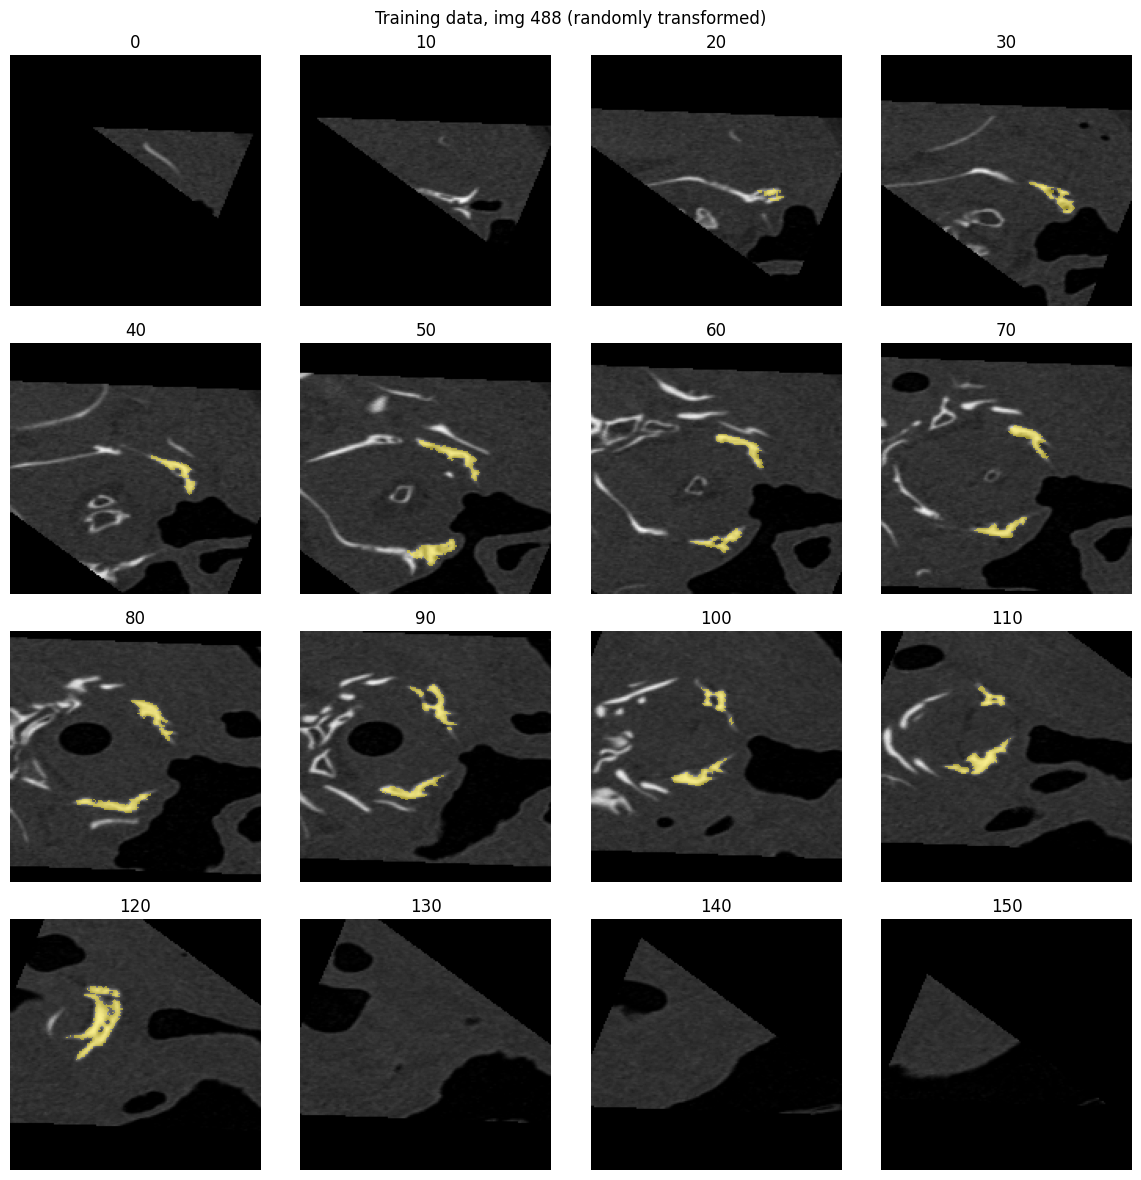

In [9]:
from dev import plot

data = train_data[0]
fig, _ = plot.plot_arr(
    image_io.pytorch2img(data[tio.IMAGE][tio.DATA].squeeze()),
    image_io.pytorch2img(data[tio.LABEL][tio.DATA].squeeze()),
)
fig.suptitle(f"Training data, img {ns[train_idx[0]]} (randomly transformed)")
fig.tight_layout()

In [10]:
""" Create a DataLoader"""

from typing import Union

import torch
patch_size = [int(x) for x in uconf["patch_size"].split(",")]
print(f"Patch size: {patch_size}")


def dataloader(
    dataset: Union[tio.SubjectsDataset, tio.Subject], *, mode: str
) -> tuple[torch.utils.data.DataLoader, Union[tio.Queue, tio.GridSampler]]:
    """
    Create a dataloader for our data

    """
    if mode not in {"train", "val", "test"}:
        raise ValueError(f"Invalid mode: {mode}")

    # We want the training and validation to occur on random patches
    if mode in {"train", "val"}:
        if not isinstance(dataset, tio.SubjectsDataset):
            raise ValueError(
                "For training and validation, a SubjectsDataset is required"
            )

        # Choose the probability of patches being centred on each value
        label_probs = {0: 1, 1: 1}
        patch_sampler = tio.LabelSampler(
            patch_size=patch_size, label_probabilities=label_probs
        )

        patches = tio.Queue(
            dataset,
            max_length=10000,
            samples_per_volume=12,
            sampler=patch_sampler,
            num_workers=10,
        )

    else:
        if not isinstance(dataset, tio.Subject):
            raise ValueError("For testing, a Subject is required")

        # For testing, we want to evaluate on the whole image
        patches = tio.GridSampler(dataset, patch_size, patch_overlap=(4, 4, 4))

    loader = torch.utils.data.DataLoader(
        patches,
        batch_size=uconf["batch_size"],
        shuffle=False,
        num_workers=0,  # i think this should be 0 for training data, since the patches are already loaded
        pin_memory=torch.cuda.is_available(),
    )

    return loader, patches


train_loader, _ = dataloader(train_data, mode="train")
val_loader, _ = dataloader(val_data, mode="val")
test_loader, grid_sampler = dataloader(test_data, mode="test")

Patch size: [64, 64, 64]


In [ ]:
"""
Load a model

"""

from dev.segmentation import model as lib_model

torch.cuda.empty_cache()

model = lib_model.model()
# lib_model.draw_model(model, "model.pdf")

In [ ]:
"""
Create an optimiser + choose a loss function

"""

from monai.losses import TverskyLoss

optimiser = lib_model.optimiser(model)
loss = TverskyLoss(include_background=True, to_onehot_y=True, alpha=0.2)

optimiser

In [ ]:
import warnings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    # Yellow text
    yellow = "\033[33m"
    clear = "\033[0m"
    warnings.warn(f"{yellow}This might not be what you want!{clear}")
print(f"Using {device} device")

_ = model.to(device)

In [ ]:
model, train_losses, val_losses = lib_model.train(
    model,
    optimiser,
    loss,
    train_loader,
    val_loader,
    device=device,
    epochs=100,
    # lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=2),
    lr_scheduler=None,
    notebook=True
)

In [ ]:
# Find the loss for each epoch as the average of the batch losses
train_loss = [np.mean(epoch_loss) for epoch_loss in train_losses]
val_loss = [np.mean(epoch_loss) for epoch_loss in val_losses]

# Find quartiles - the mean might be outside this, which would be interesting wouldn't it
train_loss_upper = [np.percentile(epoch_loss, 75) for epoch_loss in train_losses]
train_loss_lower = [np.percentile(epoch_loss, 25) for epoch_loss in train_losses]

val_loss_upper = [np.percentile(epoch_loss, 75) for epoch_loss in val_losses]
val_loss_lower = [np.percentile(epoch_loss, 25) for epoch_loss in val_losses]

In [ ]:
import time
import matplotlib.pyplot as plt

fig, axis = plt.subplots()

x = np.arange(len(train_loss))
axis.plot(x, train_loss, label="Train")
axis.fill_between(x, train_loss_lower, train_loss_upper, alpha=0.5, color="C0")

axis.plot(x, val_loss, label="Validation")
axis.fill_between(x, val_loss_lower, val_loss_upper, alpha=0.5, color="C1")

axis.set_ylabel("Loss")
axis.set_xlabel("Epoch")
axis.legend()

fig.savefig(f"plots/loss_{time.time()}_lr_{uconf['learning_rate']}.png")

In [ ]:
_ = model.to("cpu")

In [ ]:
"""
Show the result on the test data

"""

agg_kw = {"sampler": grid_sampler, "overlap_mode": "hann"}
pred_aggregator = tio.inference.GridAggregator(**agg_kw)
img_aggregator = tio.inference.GridAggregator(**agg_kw)
truth_aggregator = tio.inference.GridAggregator(**agg_kw)

# Our image is smaller than 1 batch, so we can just do it all at once
batch = []
locations = []
truth = []
for patch in grid_sampler:
    gpu_patch = patch[tio.IMAGE][tio.DATA].unsqueeze(0)
    truth_patch = patch[tio.LABEL][tio.DATA].unsqueeze(0)

    locations.append(patch[tio.LOCATION])
    batch.append(gpu_patch)
    truth.append(truth_patch)

batch_tensor = torch.cat(batch, dim=0)
truth_tensor = torch.cat(truth, dim=0)
locations_tensor = torch.stack(locations)
patch_pred = model(batch_tensor).to("cpu").detach()

pred_aggregator.add_batch(patch_pred, locations=locations_tensor)
img_aggregator.add_batch(batch_tensor, locations=locations_tensor)
truth_aggregator.add_batch(truth_tensor, locations=locations_tensor)

prediction = pred_aggregator.get_output_tensor()[1].numpy()
image = img_aggregator.get_output_tensor()[0].numpy()
truth = truth_aggregator.get_output_tensor()[0].numpy()

In [ ]:
fig, axis = plot.plot_arr(image, prediction)
fig.suptitle("Model Prediction")
fig.tight_layout()

In [ ]:
fig, axis = plot.plot_arr(image, truth)
fig.suptitle(f"Ground Truth, image {ns[test_idx[0]]}")
fig.tight_layout()

In [ ]:
plot.plot_arr(truth, prediction)